## Observational social learning task with an LMU to remember all observations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
from scipy.integrate import quad, quad_vec
from scipy.special import legendre
from lmu_networks import *
from learning_rules import *

### Task is defined by the Environment node

In [2]:
class Environment():
    def __init__(self, prob_A, time_sample=0.5, dt=0.001, seed_env=5):
        self.rng = np.random.RandomState(seed=seed_env)
        self.prob_A = prob_A
        self.prob_B = 1 - prob_A
        self.time_sample = time_sample
        self.dt = dt
        self.obs = 0
        self.weight = 0
    def sample(self, t):
        if t % self.time_sample < self.dt:
            self.obs = 1 if self.rng.uniform(0,1) < self.prob_A else -1
            self.n_sample = int(t / self.time_sample)
            self.weight = 1 / (self.n_sample + 1)
        return [self.obs, self.weight]

In [3]:
def compute_D(q):
    # Calculate the (1 x q) decoders that compute the average over the memory window (theta) from m(t)
    D = []
    for i in range(q):  # loop from i=0 to i=q-1
        P = lambda x: legendre(i)(2 * x - 1)  # shifted legendre polynomials for order i
        result = quad(P, 0, 1, epsabs=1e-5)[0]  # integrate from 0 to 1
        D.append(result)
    return np.array(D).reshape(-1, 1).T

In [14]:
def cumulative_average(a):
    return np.cumsum(a) / np.arange(1, len(a) + 1)

## Build the network

In [4]:
def build_network(env, n_neurons=1500, seed_net=0, syn_feedback=0.1, theta=6, q=10, lmu='process'):
    net = nengo.Network(seed=seed_net)
    func_obs = lambda t: env.sample(t)[0]
    # func_weight = lambda t: env.sample(t)[1]
    func_choice = lambda x: -1 if x[0] < 0 else 1
    # func_confidence = lambda x: np.abs(x[0])
    D = compute_D(q)
    func_lmu_out = lambda x: D @ x
    theta_start = 0.1
    theta_end = theta
    T = theta_end
    dt = 0.001
    theta_rate = (theta_start/theta_end)**(1/(1 + int(T/dt))) # if using cumulative modulation
    func_theta = lambda t: theta_rate

    with net:
        # external inputs
        net.input_obs = nengo.Node(func_obs)
        # net.input_weight = nengo.Node(func_weight)
        net.input_theta = nengo.Node(func_theta)
        # ensembles
        net.obs = nengo.Ensemble(n_neurons, 1)
        # net.weight = nengo.Ensemble(n_neurons, 1)
        if lmu=='process':
            net.memory = nengo.Node(LMUProcess(theta, q))
        elif lmu=='network':
            net.memory = LMUNetwork(n_neurons, theta, q, tau=syn_feedback, radius=1.5)
        elif lmu=='modulated_process':
            lmu_process = LMUModulatedProcessOld(theta=theta_start, q=q)
            net.memory = nengo.Node(lmu_process)
            net.recall = nengo.Node(size_in=1)
            delay_matrix = np.kron(np.eye(1), lmu_process.get_weights_for_delays(1))
            nengo.Connection(net.memory, net.recall, transform=delay_matrix)
        elif lmu=='modulated_network':
            net.memory = LMUModulatedNetwork(n_neurons, theta=theta_start, q=q, tau=syn_feedback)
        net.lmu_out = nengo.Ensemble(n_neurons, q, radius=3)
        net.average = nengo.Ensemble(n_neurons, 1)
        net.decision = nengo.Ensemble(n_neurons, 2, radius=1.4)
        # connections
        nengo.Connection(net.input_obs, net.obs)
        # nengo.Connection(net.input_weight, net.weight)
        if lmu=='process':
            nengo.Connection(net.obs, net.memory)
            nengo.Connection(net.memory, net.lmu_out)
        elif lmu=='network':
            nengo.Connection(net.obs, net.memory.input)
            nengo.Connection(net.memory.output, net.lmu_out)
        elif lmu=='modulated_process':
            nengo.Connection(net.obs, net.memory[1])
            nengo.Connection(net.input_theta, net.memory[0], synapse=None)
            nengo.Connection(net.memory, net.lmu_out)            
        elif lmu=='modulated_network':
            nengo.Connection(net.obs, net.memory.input)
            nengo.Connection(net.input_time, net.memory.modulator)
            nengo.Connection(net.memory.output, net.lmu_out)
        nengo.Connection(net.lmu_out, net.average, function=func_lmu_out)
        nengo.Connection(net.average, net.decision[0], function=func_choice)
        # nengo.Connection(net.average, net.decision[1], function=func_confidence)
        # probes
        net.probe_input = nengo.Probe(net.input_obs, synapse=0.01)
        net.probe_obs = nengo.Probe(net.obs, synapse=0.01)
        # net.probe_weight = nengo.Probe(net.weight, synapse=0.01)
        if lmu=='process' or lmu=='modulated_process':
            net.probe_memory = nengo.Probe(net.memory, synapse=0.01)
            net.probe_recall = nengo.Probe(net.recall, synapse=None)
        elif lmu=='network' or lmu=='modulated_network':
            net.probe_memory = nengo.Probe(net.memory.output, synapse=0.01)
        net.probe_lmu_out = nengo.Probe(net.lmu_out, synapse=0.01)
        net.probe_average = nengo.Probe(net.average, synapse=0.01)
        net.probe_decision = nengo.Probe(net.decision, synapse=0.01)
    return net

### Simulate the network for one observation

In [5]:
def simulate(time_sim, seed_sim=0, seed_env=0, seed_net=0, lmu='process'):
    env = Environment(prob_A=0.8, seed_env=seed_env)
    net = build_network(env, seed_net=seed_net, lmu=lmu, theta=time_sim)
    sim = nengo.Simulator(net, seed=seed_sim)
    with sim:
        sim.run(time_sim)
    return net, sim

### Experiment 1

In [16]:
net, sim = simulate(time_sim=3, seed_env=5, lmu='network')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

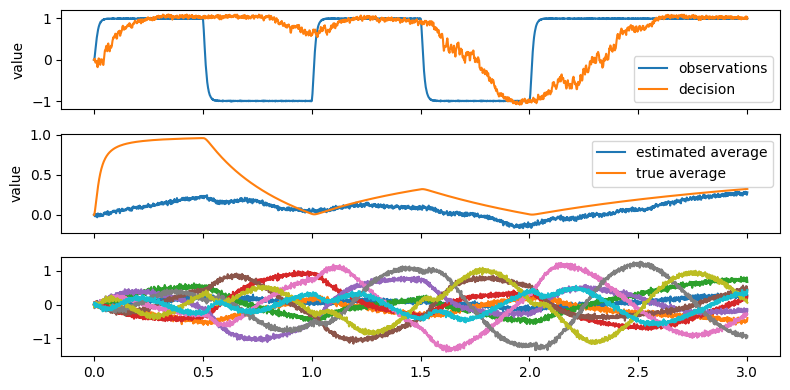

In [17]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input].flatten()
obs = sim.data[net.probe_obs].flatten()
# weights = sim.data[net.probe_weight].flatten()
mem = sim.data[net.probe_memory]
lmu_out = sim.data[net.probe_lmu_out]
avg = sim.data[net.probe_average].flatten()
true_avg = cumulative_average(sim.data[net.probe_obs])
decision = sim.data[net.probe_decision][:,0].flatten()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,4), sharex=True, sharey=False)
# sns.lineplot(x=times, y=input_obs, ax=ax, label='true observations', color='k')
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
# sns.lineplot(x=times, y=weights, ax=axes[0], label='weights')
# for q in range(mem.shape[1]):
#     sns.lineplot(x=times, y=mem[:,q], ax=axes[2])
# sns.lineplot(x=times, y=np.max(mem, axis=1), ax=axes[1], label='memory mag')
for q in range(mem.shape[1]):
    sns.lineplot(x=times, y=lmu_out[:,q], ax=axes[2])
sns.lineplot(x=times, y=avg, ax=axes[1], label='estimated average')
sns.lineplot(x=times, y=true_avg, ax=axes[1], label='true average')
sns.lineplot(x=times, y=decision, ax=axes[0], label='decision')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value')
plt.tight_layout()

## Experiment 2

In [9]:
# n_trials = 10
# trues = []
# estimates = []
# for trial in range(n_trials):
#     net, sim = simulate(time_sim=6, seed_env=trial, seed_net=trial, lmu='process')
#     obs = sim.data[net.probe_obs].flatten()
#     avg = sim.data[net.probe_average].flatten()
#     trues.append(np.mean(obs))
#     estimates.append(avg[-1])
#     print(f"trial {trial}, delta {np.abs(trues[-1] - estimates[-1]):.3}")

In [10]:
# n_trials = 10
# trues = []
# estimates = []
# for trial in range(n_trials):
#     net, sim = simulate(time_sim=6, seed_env=trial, seed_net=trial, lmu='network')
#     obs = sim.data[net.probe_obs].flatten()
#     avg = sim.data[net.probe_average].flatten()
#     trues.append(np.mean(obs))
#     estimates.append(avg[-1])
#     print(f"trial {trial}, delta {np.abs(trues[-1] - estimates[-1]):.3}")